# SPDE

In this tutorial, we show how the use of SPDE for Varying Anisotropy in the Simulation process

In [ ]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

In [ ]:
import gstlearn as gl
import gstlearn.plot as gp
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import random
import math

Defining some global parameters

In [2]:
#Extension of the simulation grid
nxmax = 500 
nymax = 200

#Well Definition
nwell = 6
vlag  = 3

#Anisotropy ratio 
ratio=1.5          
range=150

#Some seeds
seed1  = 34556643
seed2  = 244212
seednc = 432432
seedw  = 2432145

# Color Scale
zlim = [-1.6, 2.5]

nostatKeys = ["A","R2"]

# Graphic scale
gp.setDefault(dims=[10,7])

Internal function

In [3]:
def make_well(db,res,nwell=nwell,vlag=vlag,seed=seedw):
  nxmax = res.getNX(0)
  indexes = gl.VectorHelper.sampleRanks(ntotal=nxmax, number=nwell, seed=seed, optSort=1)
    
  x1 = np.ones(0)
  x2 = np.ones(0)
  for i in indexes:
    bot = math.ceil(db[i,"W1"])
    top = math.floor(db[i,"W2"])
    temp = np.arange(bot, top, step=vlag)
    x1 = np.concatenate((x1, i * np.ones(len(temp), dtype=int) + 0.2))
    x2 = np.concatenate((x2, temp))

  db_sample = gl.Db.createFromSamples(len(x1),gl.ELoadBy.COLUMN,np.concatenate((x1,x2)))
  db_sample.setName("New.1","x1")
  db_sample.setName("New.2","x2")
  db_sample.setLocator("x1",gl.ELoc.X,0)
  db_sample.setLocator("x2",gl.ELoc.X,1)
  err = gl.migrate(res, db_sample, "*simu*")
  return db_sample

Simulating the layer boundaries

In [4]:
db = gl.DbGrid.create(nx=nxmax)
model = gl.Model.createFromParam(gl.ECov.GAUSSIAN,range=200,space=gl.SpaceRN(1))
err = gl.simtub(None,dbout=db,model=model,nbtuba=1000,seed=seed1,namconv=gl.NamingConvention("W1"))
err = gl.simtub(None,dbout=db,model=model,nbtuba=1000,seed=seed2,namconv=gl.NamingConvention("W2"))
db["W1"]=db["W1"]-min(db["W1"])
db["W2"]=db["W2"]-min(db["W2"])
db["W2"]=db["W1"]+db["W2"]+1
db["W1"]=nymax*db["W1"]/max(db["W2"])
db["W2"]=nymax*db["W2"]/max(db["W2"])
db.display()


Data Base Grid Characteristics

Data Base Summary
-----------------
File is organized as a regular grid
Space dimension              = 1
Number of Columns            = 4
Maximum Number of UIDs       = 4
Total number of samples      = 500

Grid characteristics:
---------------------
Origin :      0.000
Mesh   :      1.000
Number :        500

Variables
---------
Column = 0 - Name = rank - Locator = NA
Column = 1 - Name = x1 - Locator = x1
Column = 2 - Name = W1 - Locator = NA
Column = 3 - Name = W2 - Locator = z1
 

Plotting the limits of the layer

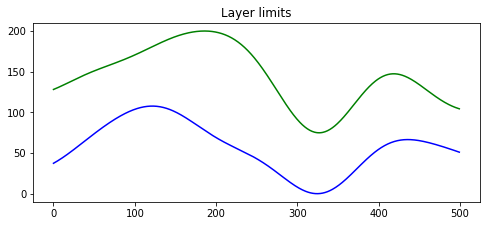

In [5]:
ax = gp.grid1Dold(db,name="W1", color="blue")
ax = gp.grid1Dold(db,name="W2", color="green", ax=ax)
ax.decoration(title="Layer limits")

Creation of the varying anisotropy ("directed" by the two layers)

In [6]:
model = gl.Model.createFromParam(gl.ECov.BESSEL_K,range=range,param=1,space=gl.SpaceRN(2))
dbgrid = gl.DbGrid.create([nxmax,nymax])
ind = (dbgrid["x1"]).reshape(1,-1)[0].astype(int)
dbgrid["sel"] = (dbgrid["x2"] > db[ind,"W1"]) & (dbgrid["x2"] < db[ind,"W2"])
anglesi = np.arctan(db["W1"][1:]-db["W1"][:-1])/np.pi*180
angless = np.arctan(db["W2"][1:]-db["W2"][:-1])/np.pi*180
anglesi = np.insert(anglesi, 0, anglesi[0])
angless = np.insert(angless, 0, angless[0])

aniso = (dbgrid["x2"]-db[ind,"W1"]) / (db[ind,"W2"]-db[ind,"W1"])
aniso = anglesi[ind] + aniso * (angless[ind]-anglesi[ind])
ratio = ratio*(db[ind,"W2"]-db[ind,"W1"])/max(db["W2"]-db["W1"])

dbgrid.addColumns(aniso,"aniso")
dbgrid.addColumns(ratio,"ratio")
dbgrid.setLocator("sel",gl.ELoc.SEL)
dbgrid.setLocators(["aniso","ratio"],gl.ELoc.NOSTAT)
dbgrid.display()


Data Base Grid Characteristics

Data Base Summary
-----------------
File is organized as a regular grid
Space dimension              = 2
Number of Columns            = 6
Maximum Number of UIDs       = 6
Total number of samples      = 100000
Number of active samples     = 43700

Grid characteristics:
---------------------
Origin :      0.000     0.000
Mesh   :      1.000     1.000
Number :        500       200

Variables
---------
Column = 0 - Name = rank - Locator = NA
Column = 1 - Name = x1 - Locator = x1
Column = 2 - Name = x2 - Locator = x2
Column = 3 - Name = sel - Locator = sel
Column = 4 - Name = aniso - Locator = nostat1
Column = 5 - Name = ratio - Locator = nostat2
 

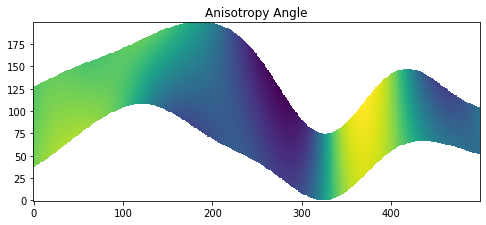

In [7]:
ax = dbgrid.plot("aniso")
ax.decoration(title="Anisotropy Angle")

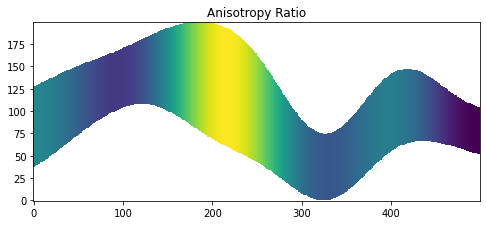

In [8]:
ax = dbgrid.plot("ratio")
ax.decoration(title="Anisotropy Ratio")

Display the anisotropy maps (on a coarser grid)

Creating the Meshing 

In [9]:
mesh = gl.MeshETurbo.createFromGrid(dbgrid, mode=0)

Assigning non-stationarity to the Model

In [10]:
dbcoarse = dbgrid.coarsify([20,20])
nostat = gl.NoStatArray(nostatKeys, dbcoarse)
err = model.addNoStat(nostat)
model.display()


Model characteristics
Space dimension              = 2
Number of variable(s)        = 1
Number of basic structure(s) = 1
Number of drift function(s)  = 0
Number of drift equation(s)  = 0

Covariance Part
---------------
K-Bessel (Third Parameter = 1)
- Sill         =      1.000
- Range        =    150.000
- Theo. Range  =     43.301
Total Sill     =      1.000

Non-Stationary Parameters
-------------------------
Angle      : GRF=1 Str=1 V#1=1
Range      : GRF=1 Str=1 V#1=2
 

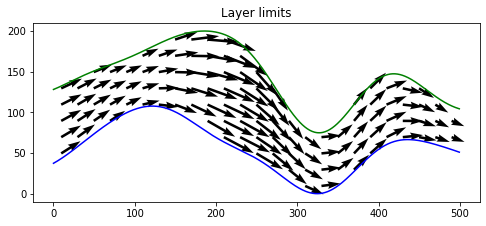

In [11]:
ax = gp.modelOnGridold(model=model, db=dbcoarse, scale=50)
ax = gp.grid1Dold(db,name="W1", color="blue", ax=ax)
ax = gp.grid1Dold(db,name="W2", color="green", ax=ax)
ax.decoration(title="Layer limits")

In [12]:
nostat = gl.NoStatArray(nostatKeys, dbgrid)
err = model.addNoStat(nostat)

## Non conditional simulation

In [13]:
spdeRes = gl.SPDE()
spdeRes.init(model=model,field=dbgrid,calc=gl.ESPDECalcMode.SIMUNONCOND, mesh=mesh)
spdeRes.compute()

Process the simulation on the output grid and visualize the result (the resulting variable is stored in rank 'iuid' and name 'spde.simu'.

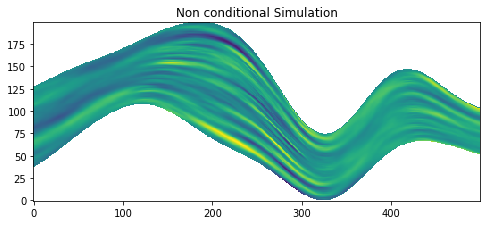

In [14]:
iuid = spdeRes.query(dbgrid, namconv=gl.NamingConvention("spde",False))
ax = dbgrid.plot("spde.simu")
ax.decoration(title="Non conditional Simulation")

## Kriging

Creating a set of fictitious wells (extracted from the non-conditional simulation)

In [15]:
db_sample = make_well(db,dbgrid,nwell=nwell,vlag=vlag,seed=seedw)

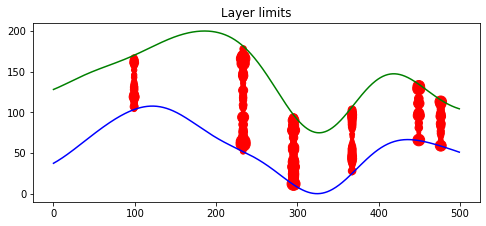

In [16]:
ax = gp.grid1Dold(db,name="W1", color="blue")
ax = gp.grid1Dold(db,name="W2", color="green", ax=ax)
ax = gp.pointold(db_sample, coorY_name="x2", ax=ax)
ax.decoration(title="Layer limits")

In [17]:
spdeRes = gl.SPDE()
spdeRes.setNIterMax(5000)
spdeRes.init(model=model,field=dbgrid,data=db_sample,calc=gl.ESPDECalcMode.KRIGING,mesh=mesh)
spdeRes.compute()

In [ ]:
iuid = spdeRes.query(dbgrid, namconv=gl.NamingConvention("spde",False))
dbgrid.display()
ax = dbgrid.plot("spde.kriging")
ax.decoration(title="Kriging")

## Conditional Simulation

In [ ]:
spdeRes = gl.SPDE()
spdeRes.init(model=model,field=dbgrid,data=db_sample,calc=gl.ESPDECalcMode.SIMUCOND,mesh=mesh)
spdeRes.compute()

In [ ]:
iuid = spdeRes.query(dbgrid, namconv=gl.NamingConvention("spde",False))
dbgrid.display()
ax = dbgrid.plot("spde.condSimu")
ax.decoration(title="Conditional Simulation")